In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline


from tqdm import tqdm
import pickle

import jax.numpy as np

from haiku._src.nets.resnet import  ResNet18
import haiku as hk

import tensorflow_datasets as tfds
import tensorflow as tf


from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfd = tfp.distributions

from sbi_lens.gen_dataset.lensing_lognormal_dataset import LensingLogNormalDataset
from sbi_lens.gen_dataset.utils import augmentation_noise, augmentation_flip
from sbi_lens.config import config_lsst_y_10

'unset XLA_FLAGS'

Populating the interactive namespace from numpy and matplotlib


/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
2023-09-12 09:42:24.199606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/gpfslocalsup/pub/anaconda-py3/2021.05/envs/python-3.10.4/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


'unset XLA_FLAGS'

#### Deal with Warnings 

In [3]:
import logging



logger = logging.getLogger("root")


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())


### Define which loss function we have used for the compression 

In [4]:
model='gnll'

### Load the parameters of the compressor and an example map 

In [4]:
# with open("/gpfs7kw/linkhome/rech/genmfd01/ulm75uc/sbi_lens/sbi_lens/data/params_compressor/params_nd_compressor_{}.pkl".format(model), 'rb') as f:
#     parameters_compressor = pickle.load(f)

# with open("/gpfs7kw/linkhome/rech/genmfd01/ulm75uc/sbi_lens/sbi_lens/data/params_compressor/opt_state_resnet_{}.pkl".format(model), 'rb') as g:
#     opt_state_resnet = pickle.load(g)



with open("/gpfs7kw/linkhome/rech/genmfd01/ulm75uc/VMIM-vs-MSE-/notebook/params_nd_compressor_gnll_fix.pkl", 'rb') as f:
    parameters_compressor = pickle.load(f)

with open("/gpfs7kw/linkhome/rech/genmfd01/ulm75uc/VMIM-vs-MSE-/notebook/opt_state_resnet_gnll_fix.pkl", 'rb') as g:
    opt_state_resnet = pickle.load(g)
    
m_data = np.load("/gpfs7kw/linkhome/rech/genmfd01/ulm75uc/sbi_lens/sbi_lens/data/m_data__256N_10ms_27gpa_0.26se.npy")
    

/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


### Augmentation

In [5]:
dim = 6

N = config_lsst_y_10.N
map_size = config_lsst_y_10.map_size
sigma_e = config_lsst_y_10.sigma_e
gals_per_arcmin2 = config_lsst_y_10.gals_per_arcmin2
nbins = config_lsst_y_10.nbins
a = config_lsst_y_10.a
b = config_lsst_y_10.b
z0 = config_lsst_y_10.z0

truth = config_lsst_y_10.truth

params_name = config_lsst_y_10.params_name


augmentation = lambda example: augmentation_flip(
  augmentation_noise(
    example=example,
    N=N,
    map_size=map_size,
    sigma_e=sigma_e,
    gal_per_arcmin2=gals_per_arcmin2,
    nbins=nbins,
    a=a,
    b=b,
    z0=z0
  )
)


#### Define the compressor

In [7]:
compressor = hk.transform_with_state(
lambda y : ResNet18(dim)(y, is_training=False))

### Load the data

In [8]:

ds = tfds.load(
  'LensingLogNormalDataset/year_10_without_noise_score_density',
  split='train', 
data_dir = 'tensorflow_dataset'
)


ds = ds.repeat()
ds = ds.shuffle(1000)
ds = ds.map(augmentation)
ds = ds.batch(128)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds))

2023-09-12 10:06:36.935097: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
y_comp.shape

(128, 6)

In [12]:
total_steps=900
theta = []
theta_s=[]
Sigma_s=[]

for batch in tqdm(range(total_steps)):
  example = next(ds_train)
  y_comp,_ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      example['simulation']
    )

  theta.append(example['theta'])
  # if model=='ngll':
  #     theta_s.append(y_comp[:,:6])
  #     Sigma_s.append(y_comp[:,6:])
  # else:
  theta_s.append(y_comp[:,:])



100%|██████████| 900/900 [18:19<00:00,  1.22s/it]


In [13]:
name_parameters= ['$\Omega_c$', '$\Omega_b$', '$\sigma_8$', '$h_0$', '$n_s$', '$w_0$']

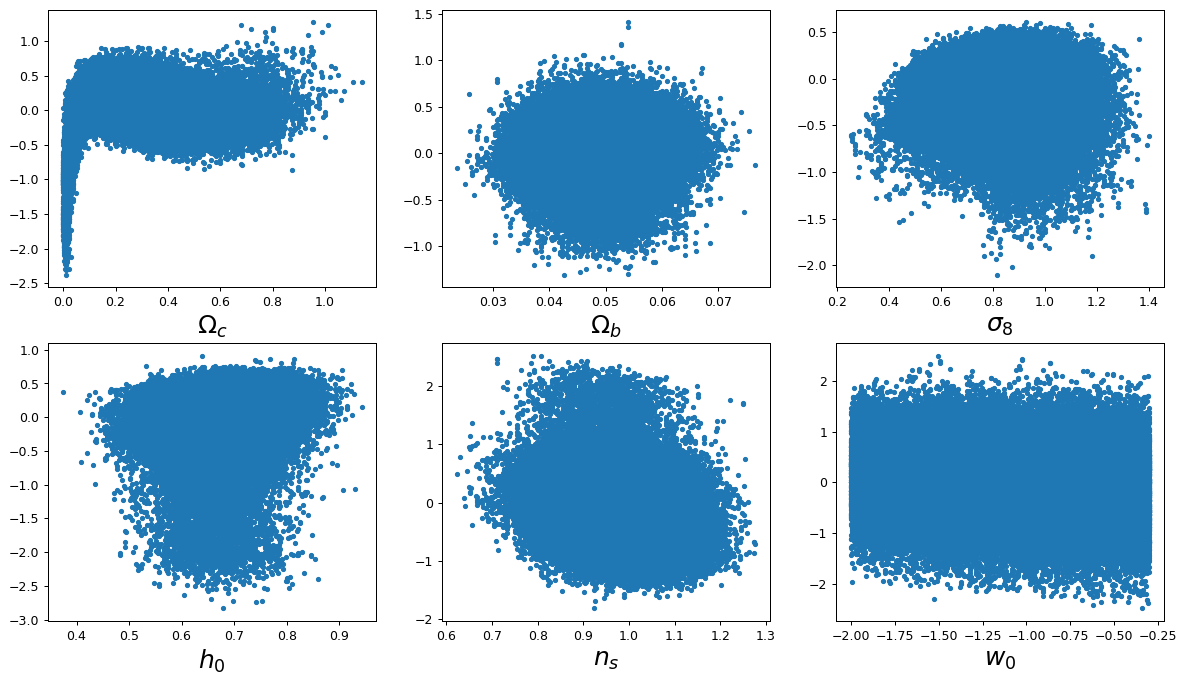

In [11]:
ticks_size = 18
f, axes = plt.subplots(2, 3,  figsize=(16,9), dpi=90)
for i, ax, name in zip(range(6), axes.ravel(),name_parameters):
    x=np.concatenate(theta,axis=0)[:,i]
    y=np.concatenate(theta_s,axis=0)[:,i]
    x= x[~numpy.isnan(y)]
    y = y[~numpy.isnan(y)]
    ax.scatter(x,y, s=10)
    ax.set_xlabel(name, fontsize=20)

In [17]:
model='ngll'

In [18]:
if model=='ngll':
    dataset = {
        'theta': np.concatenate(theta, axis=0),  
        'theta_s':np.concatenate(theta_s, axis=0), 
        # 'Sigma_s':np.concatenate(Sigma_s, axis=0), 
    }
else:
        dataset = {
        'theta': np.concatenate(theta, axis=0),  
        'theta_s':np.concatenate(theta_s, axis=0), 
    }
y, _ = compressor.apply(
   parameters_compressor, opt_state_resnet, None, m_data.reshape([1,256,256,5])
)



In [20]:
np.savez('LOADED&COMPRESSED_{}_year_10_without_noise_score_density.npz'.format(model), dataset)
np.save('COMPRESSED_fiducial_{}_year_10_without_noise_score_density'.format(model), y)
